<a href="https://colab.research.google.com/github/mr-nudo/neuronModels1/blob/master/Building_an_Oscillator_(nengo_to_numpy).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
!pip install nengo

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nengo

The goal here is to create a recurrent neural network with no inputs whose output is a sine wave.  The approach taken here is to define a differential equation that would trace out a sine wave, then use the nengo software toolkit to create that network, and then extract all the weights of the network so we can run the final model just in normal numpy commands.

The standard differential equation for a linear oscillator of frequency $f$ is

${dx_0 \over dt} = -x_1 2 \pi f \\ {dx_1 \over dt} = -x_0 2 \pi f$

But that oscillator would just oscillate with whatever magnitude of sine wave it starts at.  If it starts at 0,0 then it will just be a sine wave of magnitude 0, which is a straight line.  So we add a component to the differential equation that pushes the magnitude towards 1.

${dx_0 \over dt} = -x_1 2 \pi f + m x_0 * (1-x_0^2-x_1^2) \\ {dx_1 \over dt} = -x_0 2 \pi f  + m x_1 * (1-x_0^2-x_1^2)$

Now we use `nengo` to find connection weights for a network that follows this equation.  For details on how this works, take SYDE 556 or watch this set of videos: https://www.youtube.com/watch?v=w0NxFqIeyZA&list=PLX-XEf1yTMrnjFt30RQ7X6k-dfhL1fIGq.  There are a few parameters for this process:

- `neuron_type` (which we assume to be a Rectified Linear Unit (ReLU) here, for simplicity)
- `n_neurons` (number of neurons)
- `synapse` (the time constant of the reabsorption of the neurotransmitter, which is the dominant term in the dynamics for most neurotransmitters)
- `reg` (amount of regularization to use when finding the connection weights; this is the regularization term for ridge regression, so small values like 1e-10 should lead to very large connection weights and systems that do not generalize well)

The network consists of single layer of recurrently connected neurons (`ens`), all of which are connected to a single output (`output`).

In [105]:
n_neurons = 300
synapse = 0.1
reg = 0.1
dt = 0.001

model = nengo.Network()
with model:
    ens = nengo.Ensemble(n_neurons=n_neurons, dimensions=2, neuron_type=nengo.RectifiedLinear(),
                         max_rates=nengo.dists.Uniform(0.5, 1))

    def oscillator(x):
        r = 1
        f = 1
        m = 10
        return [
            synapse * (-x[1] * f * 2 * np.pi + m * x[0] * (r - x[0] ** 2 - x[1] ** 2)) + x[0],
            synapse * (x[0] * f * 2 * np.pi + m * x[1] * (r - x[0] ** 2 - x[1] ** 2)) + x[1],
        ]

    c = nengo.Connection(ens, ens, synapse=synapse, function=oscillator,
                         solver=nengo.solvers.LstsqL2(reg=reg))
    output = nengo.Node(None, size_in=1)
    c_out = nengo.Connection(ens, output, synapse=None, function=lambda x: x[0])

    p_neurons = nengo.Probe(ens.neurons)
    p_out = nengo.Probe(output)

sim = nengo.Simulator(model, dt=dt)
with sim:
    sim.run(3)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Here is what that looks like when run with Nengo

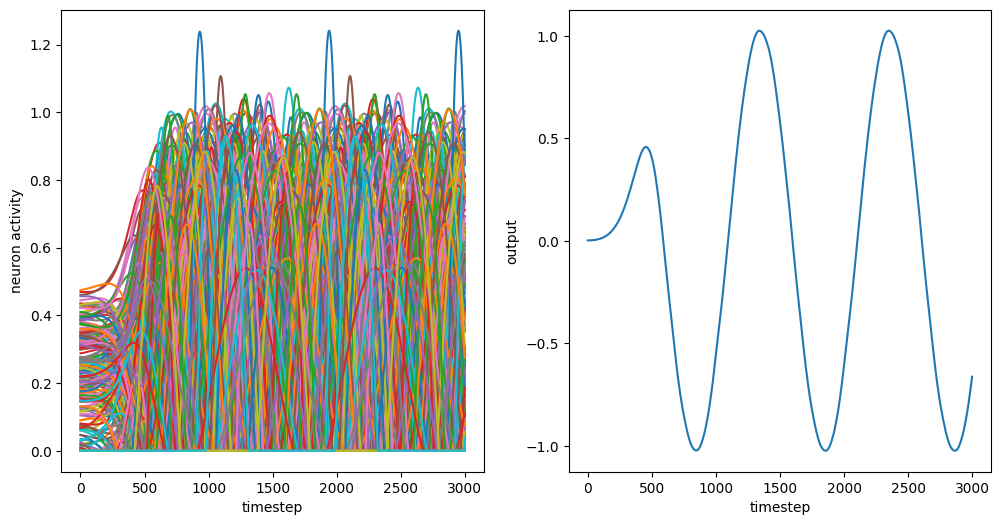

In [106]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(sim.data[p_neurons])
plt.xlabel('timestep')
plt.ylabel('neuron activity')

plt.subplot(1, 2, 2)
plt.plot(sim.data[p_out])
plt.xlabel('timestep')
plt.ylabel('output')
plt.show()


In order to run this ourselves (so that we can then modify the model in various ways), we need to get the various connection weights and neuron parameters out of nengo so that we can simulate them.

In particular, we need:
- `bias`: the constant bias input fed into each neuron
- `w_recurrent`: the recurrent connection weight matrix between each neuron
- `w_output`: the output weights from the neurons to the output.

In [107]:
bias = sim.data[ens].bias
w_recurrent = sim.data[ens].scaled_encoders @ sim.data[c].weights
w_output = sim.data[c_out].weights

We also need to implement a low-pass filter for the synapse model.  For this, we use the standard trick for implementing this assuming timesteps of `dt`:

$y_{k+1} = y_k + \alpha (x_k - y_k)$

where $\alpha$ is $1-e^{dt/\tau}$

In [108]:
alpha = 1-np.exp(-dt/synapse)

Now we can implement our model in normal numpy commands

In [109]:
I_syn = np.zeros(ens.n_neurons)       # initialize the lowpass filter synapse to zero

def rectified_linear(x):              # define the neuron model
    return np.where(x>0, x, 0)

data_out = []                         # for storing our output data
for i in range(10000):
    a = rectified_linear(I_syn)       # the output of the synapse is fed into the neurons to get the neuron activity a
    I = bias + w_recurrent @ a        # compute the total input to the synapse
    I_syn += alpha*(I - I_syn)        # implement the low-pass filter for the synapse

    out = w_output @ a                # the output is the neuron activity times the output weights
    data_out.append(out)              # record the output

And here is the resulting output

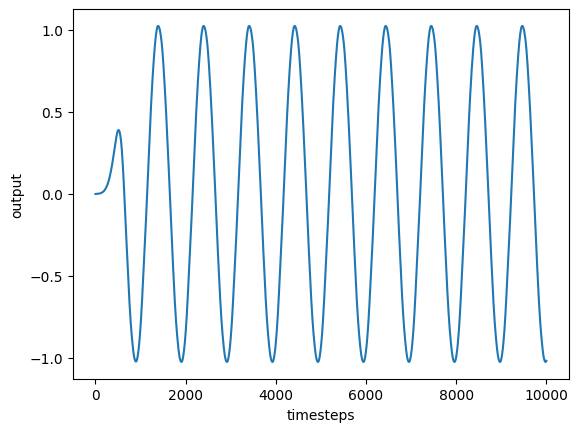

In [110]:
plt.plot(data_out)
plt.xlabel('timesteps')
plt.ylabel('output')
plt.show()

Note that the output is not exactly the same as in nengo.  That is because nengo initializes the activity of the neurons randomly rather then setting them all to zero.  But the overall behaviour shouldn't depend on this, so we won't worry about it.

Given this model, you can go ahead and change the system in various ways (such as adding noise) and see what happens!

[array([0.]), array([0.00316562]), array([0.00629997]), array([0.00940369]), array([0.01247741]), array([0.01552174]), array([0.01853729]), array([0.02151654]), array([0.02446095]), array([0.02742088]), array([0.03036673]), array([0.033295]), array([0.0362064]), array([0.03908504]), array([0.04193005]), array([0.04475439]), array([0.04755844]), array([0.05039881]), array([0.05324236]), array([0.05611802]), array([0.05896158]), array([0.06169553]), array([0.06442061]), array([0.06712628]), array([0.06982347]), array([0.07250227]), array([0.0751611]), array([0.07779879]), array([0.08042238]), array([0.08306691]), array([0.08572618]), array([0.08838461]), array([0.09102848]), array([0.09365772]), array([0.09627229]), array([0.09887211]), array([0.10145715]), array([0.10402735]), array([0.10658269]), array([0.10912312]), array([0.11164862]), array([0.11415916]), array([0.11663104]), array([0.11907555]), array([0.12150295]), array([0.12388442]), array([0.12622369]), array([0.12854615]), arr

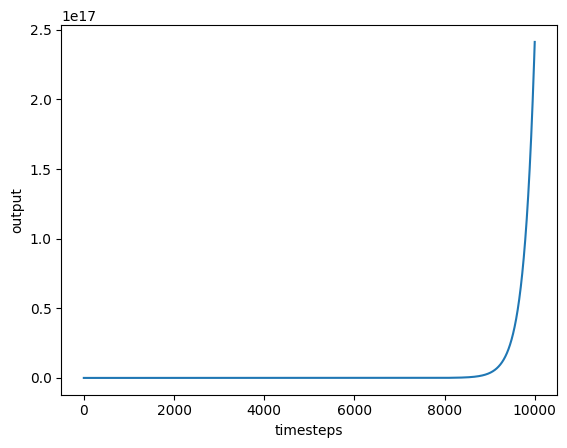

In [52]:
# Function to add random noise at the input layer
def add_noise(x, scale=0.1):
    return x + np.random.normal(scale=scale, size=x.shape)

# Add noise to bias, recurrent weights, and output weights
bias_noisy = add_noise(bias)
w_recurrent_noisy = add_noise(w_recurrent)
w_output_noisy = add_noise(w_output)

# Initialize noisy synapse
I_syn_noisy = np.zeros(ens.n_neurons)

data_out_noisy = []  # for storing output data with noise
for i in range(10000):
    a = rectified_linear(I_syn_noisy)  # neuron activity
    I_noisy = bias_noisy + w_recurrent_noisy @ a  # total input with noise
    I_syn_noisy += alpha * (I_noisy - I_syn_noisy)  # low-pass filter with noise

    out_noisy = w_output_noisy @ a  # output with noise
    data_out_noisy.append(out_noisy)  # record the output with noise

print(data_out_noisy)
plt.plot(data_out_noisy)
plt.xlabel('timesteps')
plt.ylabel('output')
plt.show()

[array([4.45825264e+65]), array([4.31821743e+65]), array([4.17843645e+65]), array([4.04086958e+65]), array([3.90510034e+65]), array([3.77217675e+65]), array([3.64434961e+65]), array([3.53599612e+65]), array([3.44270274e+65]), array([3.36441119e+65]), array([3.2876553e+65]), array([3.20898287e+65]), array([3.13279535e+65]), array([3.06005211e+65]), array([2.99193842e+65]), array([2.9264304e+65]), array([2.8607436e+65]), array([2.79631628e+65]), array([2.73615642e+65]), array([2.67362003e+65]), array([2.6107727e+65]), array([2.54919282e+65]), array([2.49554962e+65]), array([2.4549813e+65]), array([2.41440143e+65]), array([2.37650473e+65]), array([2.34160452e+65]), array([2.3076829e+65]), array([2.27432967e+65]), array([2.24100234e+65]), array([2.20821066e+65]), array([2.17583568e+65]), array([2.14624904e+65]), array([2.11672054e+65]), array([2.08560927e+65]), array([2.05322956e+65]), array([2.019127e+65]), array([1.98531325e+65]), array([1.95107596e+65]), array([1.9130174e+65]), array([1

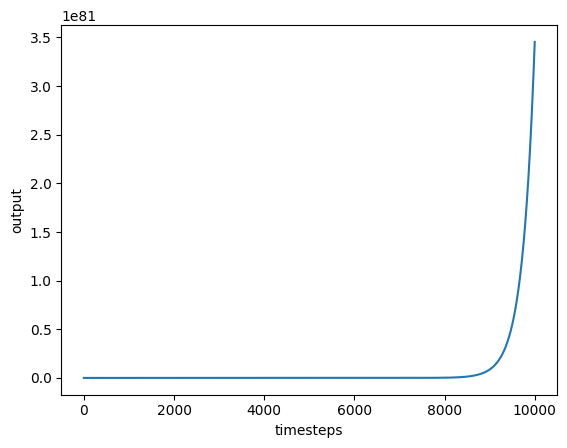

In [61]:
# Function to add noise at the parameter layer
def add_parameter_noise(x, scale=0.1):
    return x + np.random.normal(scale=scale, size=x.shape)

# Add noise to bias, recurrent weights, and output weights
bias_noisy = add_parameter_noise(bias)
w_recurrent_noisy = add_parameter_noise(w_recurrent)
w_output_noisy = add_parameter_noise(w_output)

data_out_noisy = []  # for storing output data with noise

for i in range(10000):
    a = rectified_linear(I_syn)  # neuron activity
    I_noisy = bias_noisy + w_recurrent_noisy @ a  # total input without noise
    I_syn += alpha * (I_noisy - I_syn)  # low-pass filter without noise

    out_noisy = w_output_noisy @ a  # output without noise
    data_out_noisy.append(out_noisy)  # record the output without noise

print(data_out_noisy)
plt.plot(data_out_noisy)
plt.xlabel('timesteps')
plt.ylabel('output')
plt.show()

[array([-0.80541647]), array([-0.77225545]), array([-0.84578682]), array([-0.93216075]), array([-0.83796321]), array([-0.86986671]), array([-0.7497422]), array([-0.84874218]), array([-1.02996172]), array([-1.03538949]), array([-0.98752706]), array([-0.90090863]), array([-0.9672284]), array([-0.9290799]), array([-0.76473671]), array([-0.93836476]), array([-0.72746404]), array([-0.85488217]), array([-0.89262101]), array([-0.7356596]), array([-0.99718124]), array([-0.96341542]), array([-0.86748365]), array([-1.01071572]), array([-0.98129157]), array([-0.91221395]), array([-1.07976496]), array([-0.93920582]), array([-0.90825157]), array([-0.92336035]), array([-0.70672129]), array([-0.97842914]), array([-0.96240004]), array([-0.98087133]), array([-0.89457219]), array([-1.01683573]), array([-0.82339963]), array([-1.03852019]), array([-0.96651764]), array([-1.01587063]), array([-0.90695709]), array([-0.94723616]), array([-0.8934612]), array([-1.01635369]), array([-0.96315611]), array([-0.9738

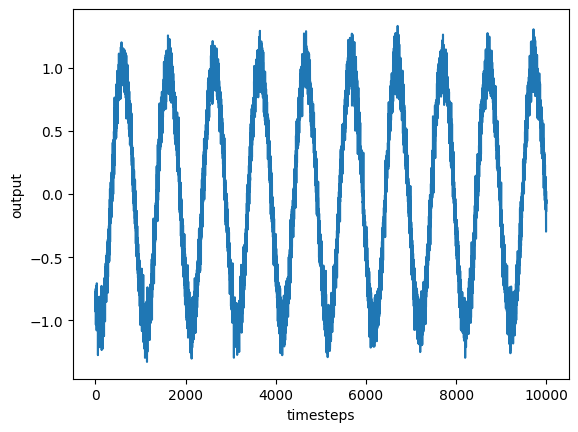

In [66]:
# Function to add output noise
def add_output_noise(x, scale=0.1):
    return x + np.random.normal(scale=scale, size=x.shape)

# Add noise to output weights
w_output_noisy = add_output_noise(w_output)

data_out_noisy = []  # for storing output data with noise

for i in range(10000):
    a = rectified_linear(I_syn)  # neuron activity
    I = bias + w_recurrent @ a  # total input without noise
    I_syn += alpha * (I - I_syn)  # low-pass filter without noise

    out_noisy = add_output_noise(w_output @ a)  # output with noise
    data_out_noisy.append(out_noisy)  # record the output with noise

print(data_out_noisy)
plt.plot(data_out_noisy)
plt.xlabel('timesteps')
plt.ylabel('output')
plt.show()


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

[array([0.98318974]), array([0.98333524]), array([0.98348848]), array([0.9836533]), array([0.98389817]), array([0.98414717]), array([0.9843942]), array([0.98463961]), array([0.98486569]), array([0.98507101]), array([0.98526782]), array([0.98545716]), array([0.9856173]), array([0.98577281]), array([0.98590283]), array([0.98598553]), array([0.98606074]), array([0.98611047]), array([0.98613146]), array([0.98614762]), array([0.98615869]), array([0.9861644]), array([0.98614454]), array([0.98607043]), array([0.98596962]), array([0.98586106]), array([0.98573848]), array([0.98559526]), array([0.98540267]), array([0.98520188]), array([0.98498345]), array([0.98474759]), array([0.98457124]), array([0.98437125]), array([0.9841359]), array([0.98386828]), array([0.98357103]), array([0.98324331]), array([0.9828843]), array([0.9824958]), array([0.98209496]), array([0.98166205]), array([0.98119641]), array([0.9806544]), array([0.9800474]), array([0.97940249]), array([0.97872174]), array([0.97800445]), 

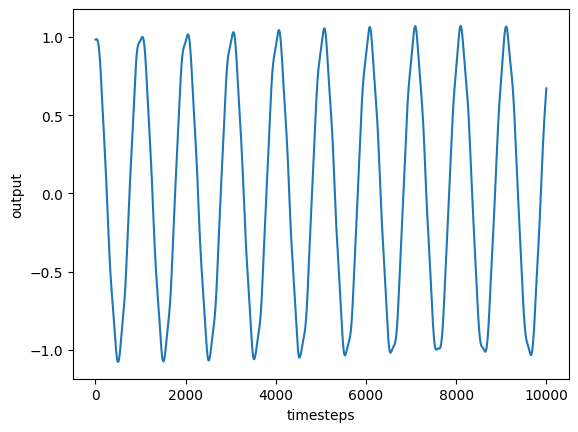

In [69]:
# Define the simulation time
sim_time = 3  # adjust as needed

# Create the Nengo Simulator object
sim = nengo.Simulator(model, dt=dt)
sim.run(sim_time)

# Define a deterministic perturbation function, for example, a sine wave
def sine_perturbation(t, frequency, amplitude):
    return amplitude * np.sin(2 * np.pi * frequency * t)

# Add deterministic perturbations to the input signal
input_perturbation_params = (sim.trange(), 5, 0.1)  # (time, frequency, amplitude)

data_out_noisy = []  # for storing output data with noise

for i in range(10000):
    # a = rectified_linear(I_syn)  # neuron activity
    # I_noisy = add_input_perturbations(bias, sine_perturbation, input_perturbation_params) + w_recurrent @ a  # total input with deterministic perturbations
    # I_syn += alpha * (I_noisy - I_syn)  # low-pass filter without noise

    # out = w_output @ a  # output without noise
    # data_out_noisy.append(out)  # record the output without noise
    t = i * dt  # current time
    perturbation = sine_perturbation(t, 5, 0.1)  # calculate perturbation for current time
    a = rectified_linear(I_syn)  # neuron activity
    I_noisy = bias + perturbation + w_recurrent @ a  # total input with deterministic perturbations
    I_syn += alpha * (I_noisy - I_syn)  # low-pass filter without noise

    out = w_output @ a  # output without noise
    data_out_noisy.append(out)  # record the output without noise

print(data_out_noisy)
plt.plot(data_out_noisy)
plt.xlabel('timesteps')
plt.ylabel('output')
plt.show()


[array([7.14812133e+112]), array([7.52937614e+112]), array([7.93096569e+112]), array([8.35397457e+112]), array([8.79954521e+112]), array([9.26888096e+112]), array([9.76324938e+112]), array([1.02839856e+113]), array([1.0832496e+113]), array([1.1410262e+113]), array([1.20188439e+113]), array([1.26598853e+113]), array([1.33351176e+113]), array([1.40463643e+113]), array([1.47955463e+113]), array([1.55846869e+113]), array([1.64159175e+113]), array([1.72914829e+113]), array([1.82137477e+113]), array([1.91852028e+113]), array([2.02084718e+113]), array([2.12863182e+113]), array([2.2421653e+113]), array([2.36175425e+113]), array([2.48772164e+113]), array([2.62040766e+113]), array([2.76017068e+113]), array([2.90738815e+113]), array([3.06245767e+113]), array([3.22579803e+113]), array([3.39785037e+113]), array([3.57907936e+113]), array([3.76997444e+113]), array([3.97105117e+113]), array([4.18285261e+113]), array([4.40595076e+113]), array([4.64094816e+113]), array([4.88847946e+113]), array([5.14921

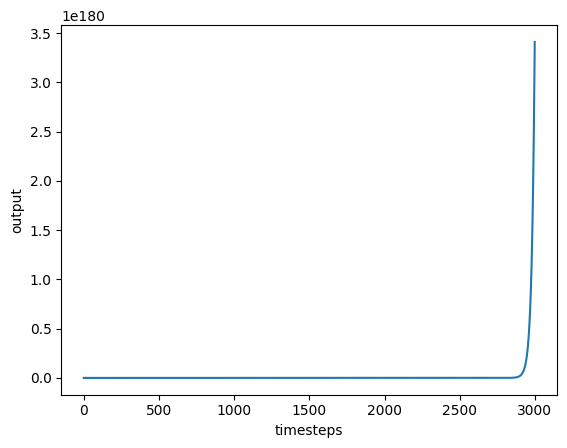

In [115]:
# Define simulation time and time array
sim_time = 3
time_array = np.linspace(0, sim_time, 3000)  # Create a time array with 3000 points

# Define perturbation parameters
parameter_perturbation_params = (sim.trange(), 1, 0.05)  # (time, frequency, amplitude)
perturbation_params = (sim.trange(), 1, np.tile(parameter_perturbation_params[2], (300,)))

# Add deterministic parameter perturbations
bias_noisy = bias + sine_perturbation(time_array[:300], 5, 0.1)
w_recurrent_noisy = w_recurrent + sine_perturbation(time_array[:300], 5, 0.1)
w_output_noisy = w_output + sine_perturbation(time_array[:300], 5, 0.1)

data_out_noisy = []  # for storing output data with noise

for i in range(3000):
    a = rectified_linear(I_syn)  # neuron activity
    I_noisy = bias_noisy + w_recurrent_noisy @ a  # total input with deterministic perturbations
    I_syn += alpha * (I_noisy - I_syn)  # low-pass filter without noise

    out = w_output_noisy @ a  # output without noise
    data_out_noisy.append(out)  # record the output without noise

print(data_out_noisy)
plt.plot(data_out_noisy)
plt.xlabel('timesteps')
plt.ylabel('output')
plt.show()

[array([ 5.53783379e+179,  1.08185462e+180,  1.60888306e+180, ...,
       -1.03147366e+180, -5.03402417e+179,  2.51904813e+178]), array([ 5.48404259e+179,  1.07122364e+180,  1.59301060e+180, ...,
       -1.02108683e+180, -4.98267447e+179,  2.50684058e+178]), array([ 5.43067473e+179,  1.06068713e+180,  1.57728463e+180, ...,
       -1.01081416e+180, -4.93194507e+179,  2.49364831e+178]), array([ 5.37773141e+179,  1.05024469e+180,  1.56170424e+180, ...,
       -1.00065400e+180, -4.88182450e+179,  2.47953454e+178]), array([ 5.32521358e+179,  1.03989590e+180,  1.54626852e+180, ...,
       -9.90604708e+179, -4.83230161e+179,  2.46455983e+178]), array([ 5.27312199e+179,  1.02964035e+180,  1.53097654e+180, ...,
       -9.80664708e+179, -4.78336557e+179,  2.44878210e+178]), array([ 5.22145719e+179,  1.01947758e+180,  1.51582734e+180, ...,
       -9.70832443e+179, -4.73500583e+179,  2.43225679e+178]), array([ 5.17021953e+179,  1.00940713e+180,  1.50081998e+180, ...,
       -9.61106395e+179, -4.68

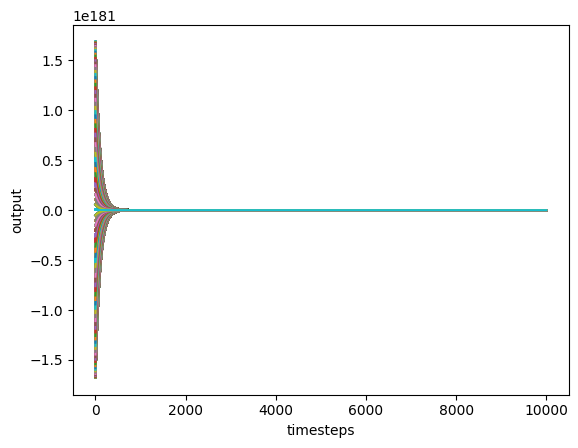

In [116]:
# Function to add deterministic output perturbations
def add_output_perturbations(x, perturbation_function, perturbation_parameters):
    return x + perturbation_function(*perturbation_parameters)

# Define perturbation parameters
output_perturbation_params = (sim.trange(), 5, 0.1)  # (time, frequency, amplitude)

# Transpose w_output to match the shape expected by the perturbation function
w_output_transposed = np.transpose(w_output)

# Add deterministic output perturbations
w_output_noisy_transposed = add_output_perturbations(w_output_transposed, sine_perturbation, output_perturbation_params)

# Transpose the perturbed output weights back to the original shape
w_output_noisy = np.transpose(w_output_noisy_transposed)

data_out_noisy = []  # for storing output data with noise

for i in range(10000):
    a = rectified_linear(I_syn)  # neuron activity
    I_noisy = bias + w_recurrent @ a  # total input without noise
    I_syn += alpha * (I_noisy - I_syn)  # low-pass filter without noise

    out_noisy = w_output_noisy @ a  # output with deterministic perturbations
    data_out_noisy.append(out_noisy)  # record the output with deterministic perturbations

# print(data_out_noisy)
plt.plot(data_out_noisy)
plt.xlabel('timesteps')
plt.ylabel('output')
plt.show()